<a href="https://colab.research.google.com/github/Shrey0997/cs666student/blob/main/CS666_Assignment_6_Shreyas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

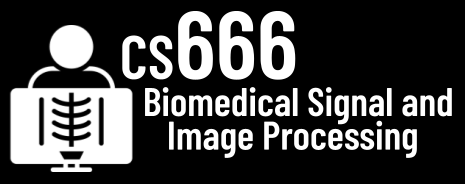
# Assignment 6

In [ ]:
# NAME: Shreyas Shirsekar

In [ ]:
# In this assignment, we will explore the new Segment-Anything-Model (https://segment-anything.com/)
# for the task of mitochondria detection in a connectomics dataset acquired using electron microscopy.
#
# We will run the following experiments:
#
# 1. Using the Segment-Anything-Model (SAM) without seeds in auto mode
#
# 2. Train a U-Net classifier from scratch
#
# 3. Evaluate the U-Net classifier
#
# 4. Use the U-Net to seed the SAM model (U-Net + SAM)
#
# 5. Compare U-Net vs. U-Net + SAM
#
# Bonus: Improve U-Net + SAM

In [ ]:
### IMPORTANT (DO THIS RIGHT AWAY!) ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
#
### IMPORTANT ###

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
# We will use mahotas as well!
!pip install mahotas --no-binary :all:
import mahotas as mh

DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# And of course, we need the data!
!wget https://cs666.org/data/mito.npz

--2023-04-25 02:01:17--  https://cs666.org/data/mito.npz
Resolving cs666.org (cs666.org)... 185.199.110.153, 185.199.111.153, 185.199.108.153, ...
Connecting to cs666.org (cs666.org)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37610178 (36M) [application/octet-stream]
Saving to: ‘mito.npz.1’

mito.npz.1          100%[===================>]  35.87M  --.-KB/s    in 0.1s    

2023-04-25 02:01:17 (303 MB/s) - ‘mito.npz.1’ saved [37610178/37610178]



## 0. Data loading (5 points)

In [7]:
# The data includes images and manually segmented masks.
loaded = np.load('mito.npz')
images = loaded['arr_0'][0]
masks = loaded['arr_0'][1]

In [5]:
# TODO: Show the first image with the gray colormap.
# TODO: YOUR_CODE

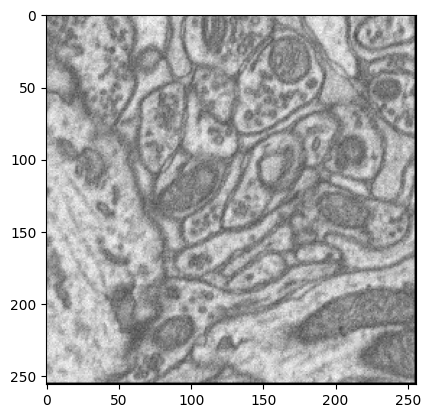

In [8]:
plt.imshow(images[0], cmap='gray')
plt.show()

In [ ]:
# TODO: Show the first mask.

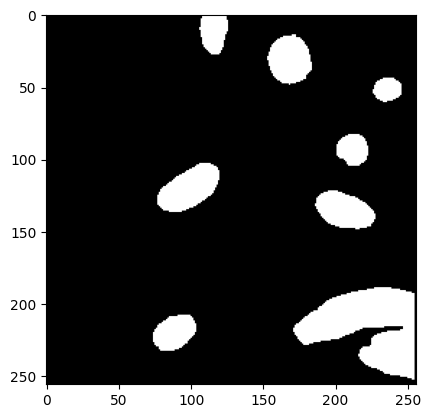

In [9]:
plt.imshow(masks[0], cmap='gray')
plt.show()

## 1. SAM in AUTO mode (15 points)

In [10]:
# We will use the METASEG package as an easy-to-use layer
# for SAM.
!pip install metaseg==0.6.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
# SAM comes in two modes, auto and with seeds
from metaseg import SegAutoMaskPredictor, SegManualMaskPredictor

In [12]:
# SAM takes files as input!
# So we have to store the numpy array to disk.
mh.imsave('first.png', images[0])

In [17]:
#
# Run SAM in auto mode on first.png and store
# the result as first_output.png.
#
results = SegAutoMaskPredictor().image_predict(
    source="first.png",
    model_type="vit_l", # vit_l, vit_h, vit_b
    points_per_side=16, 
    points_per_batch=64,
    min_area=0,
    output_path="first_output.png",
    show=False,
    save=True,
)

vit_l model already exists as 'vit_l.pth'. Skipping download.


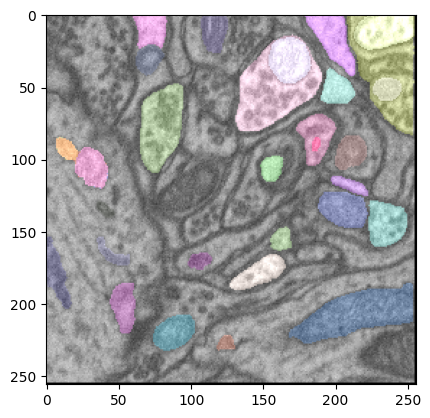

In [18]:
imshow( mh.imread('first_output.png') )

In [ ]:
# TODO: Does SAM work well for mitochondria detection?
# TODO: YOUR_ANSWER

In [ ]:
#Yes, it works well.

In [ ]:
# TODO: Try the auto predictor on your image!
# 
# Please upload your own image and test how well
# the auto mode of SAM performs!
#
# Run SAM in auto mode on that image and store
# the result as second_output.png. Show the output!
#

In [ ]:
# TODO: YOUR CODE


In [19]:
# First, converting the image from .jpg to .npy format

from PIL import Image

# Load the image file
img = Image.open('Dog.jpg')

# Convert the image to a NumPy array
img_array = np.array(img)

# Save the array to a .npy file
np.save('Dog.npy', img_array)

vit_l model already exists as 'vit_l.pth'. Skipping download.


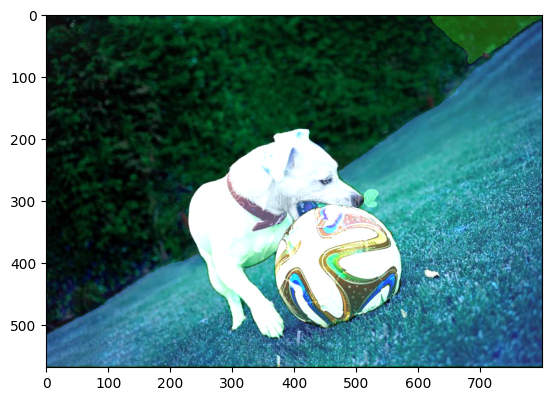

In [20]:
image = np.load('Dog.npy')

# Save the image to disk
plt.imsave('Dog.png', image)

# Run SAM in auto mode on the image and store the result as second_output.png
results = SegAutoMaskPredictor().image_predict(
    source="Dog.png",
    model_type="vit_l",
    points_per_side=16, 
    points_per_batch=64,
    min_area=0,
    output_path="Dog_new.png",
    show=False,
    save=True,
)

# Display the output
output_image = plt.imread('Dog_new.png')
plt.imshow(output_image)
plt.show()

In [ ]:
# Original Image

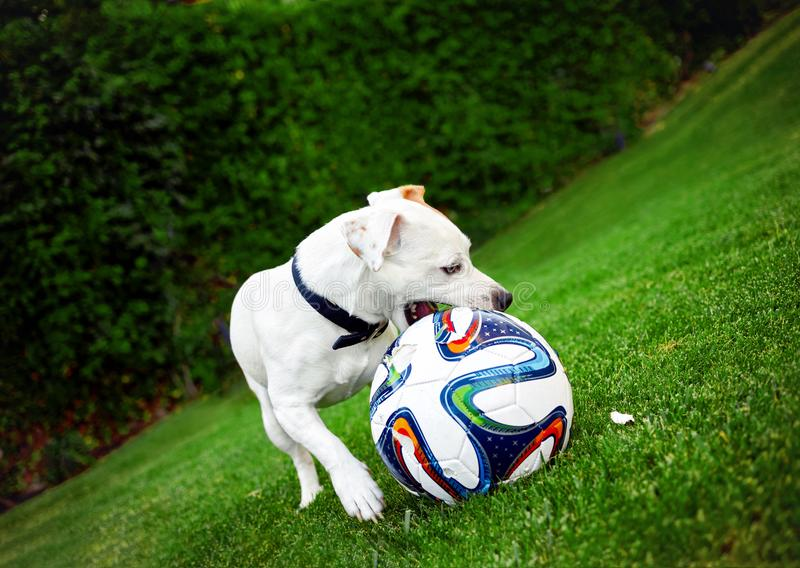

In [ ]:
# TODO: Does SAM work well on your example?
# TODO: YOUR_ANSWER

In [ ]:
#Yes, it works well.

## 2. Train a U-Net classifier from scratch (50 points)


In [21]:
# We will use the keras_unet package!
#
# HINT: There is documentation available here, if you are stuck during this part
# of the assignment: https://github.com/karolzak/keras-unet
!pip install keras_unet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
# keras_unet has convenience functions to visualize data
from keras_unet.utils import plot_imgs

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


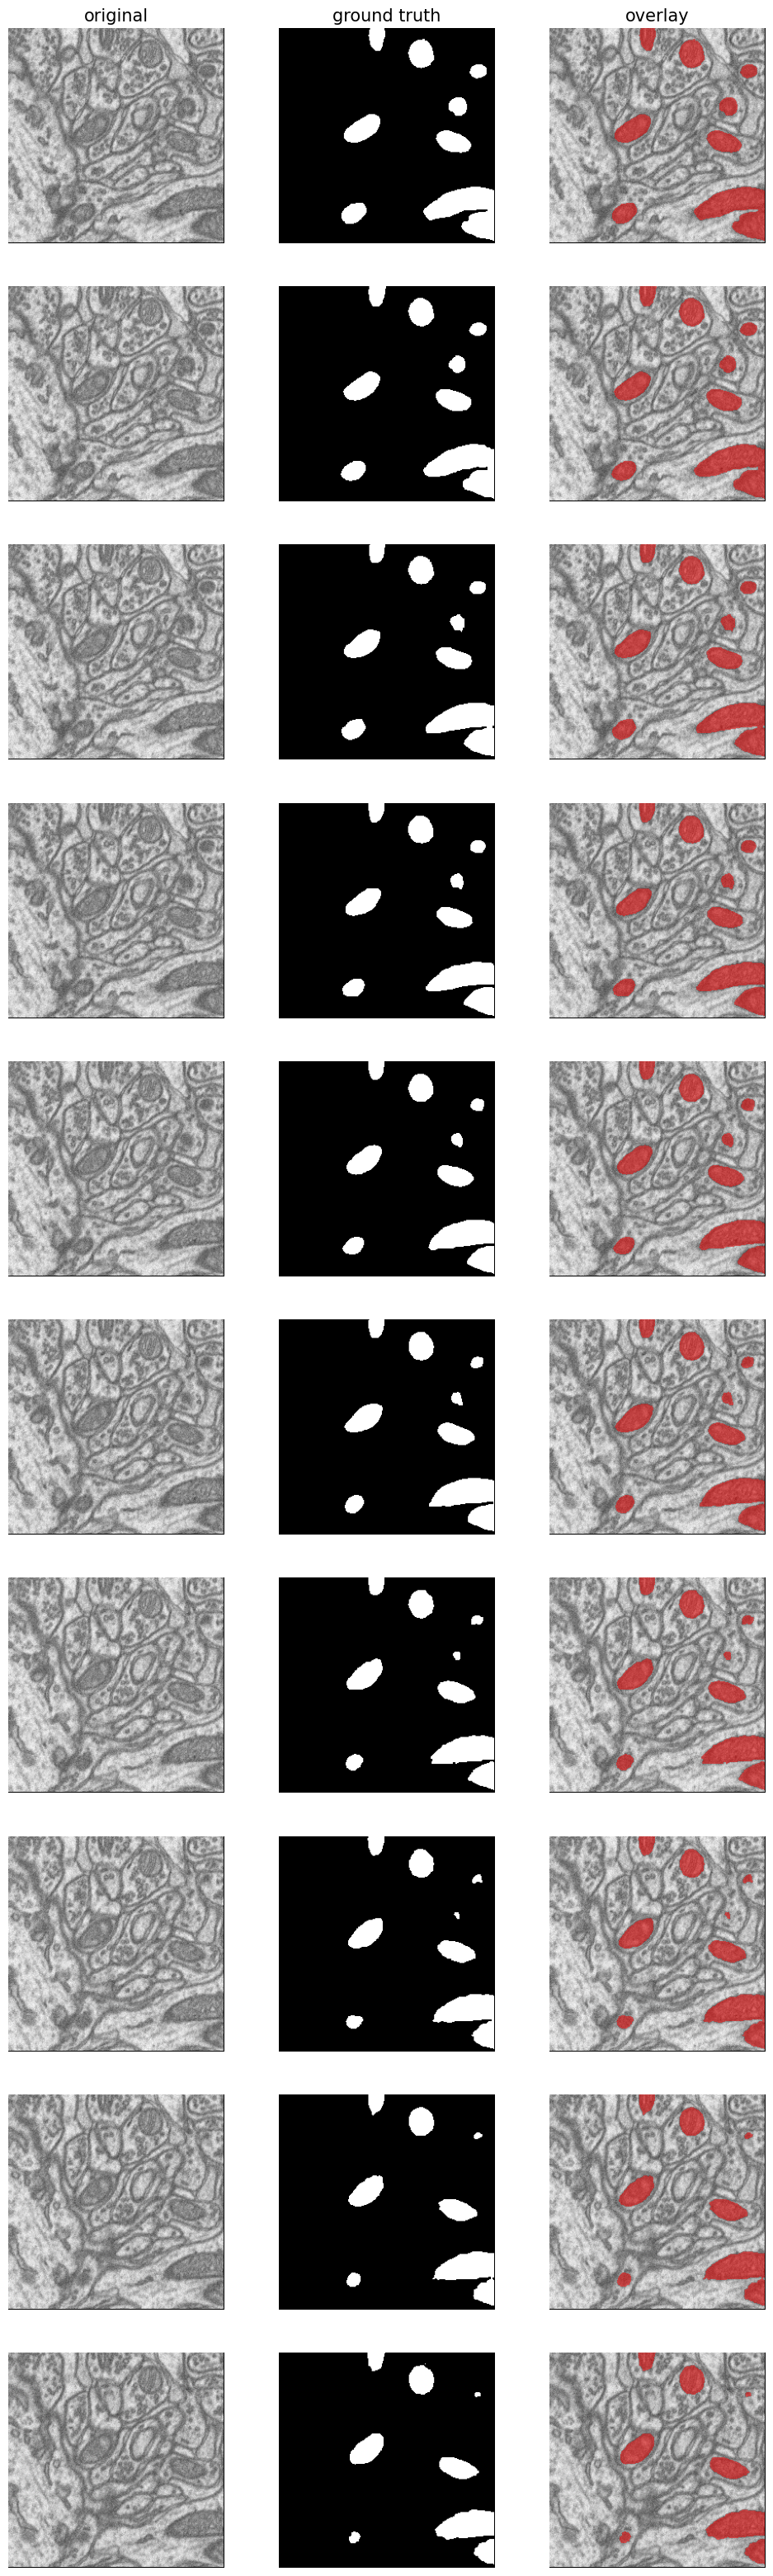

In [23]:
# Let's plot a few images and masks.
plot_imgs(org_imgs=images, mask_imgs=masks)

In [24]:
# The images are in this format.
print( images.shape, images.max(), images.dtype )

(660, 256, 256) 243 uint8


In [25]:
# TODO convert the format to the following:
# (660, 256, 256, 1) 1.0 float32
#
# 1) convert to float32
# 2) normalize to the range of 0..1
# 3) Add the last channel using .reshape like in class
#
# TODO: YOUR_CODE
# X = 

In [26]:
images = images.astype(np.float32)

# Normalize the images to the range of 0..1
images /= images.max()

# Add the last channel using .reshape
images = images.reshape(images.shape + (1,))

# Print the new format of the images array
print(images.shape, images.max(), images.dtype)

# Store the images array in X
X = images

(660, 256, 256, 1) 1.0 float32


In [27]:
# Validate that everything matches accordingly
print( X.shape, X.max(), X.dtype )

(660, 256, 256, 1) 1.0 float32


In [28]:
# The masks are in this format.
print( masks.shape, masks.max(), masks.dtype )

(660, 256, 256) 255 uint8


In [ ]:
# TODO convert the format to the following:
# (660, 256, 256, 1) True bool
#
# 1) convert to bool
# 2) Add the last channel using .reshape like in class
#
# TODO: YOUR_CODE
# y = 

In [29]:
# Convert the masks array to bool
masks = masks.astype(np.bool)

# Add the last channel using .reshape
masks = masks.reshape(masks.shape + (1,))

# Print the new format of the masks array
print(masks.shape, masks.max(), masks.dtype)

# Store the masks array in y
y = masks

(660, 256, 256, 1) True bool


<ipython-input-29-c8da810e7593>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  masks = masks.astype(np.bool)


In [30]:
# Validate that everything matches accordingly
print( y.shape, y.max(), y.dtype )

(660, 256, 256, 1) True bool


In [31]:
#
# Now we will create our train/val/test splits using scikit-learn!
#
from sklearn.model_selection import train_test_split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [34]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (369, 256, 256, 1)
y_train:  (369, 256, 256, 1)
X_val:  (159, 256, 256, 1)
y_val:  (159, 256, 256, 1)
X_test:  (132, 256, 256, 1)
y_test:  (132, 256, 256, 1)


In [ ]:
# TODO: Why do we call train_test_split twice?
# TODO: YOUR_ANSWER

In [ ]:
# We call train_test_split() twice to split the original dataset into three subsets: train, validation, and test. 
# The first call to train_test_split() splits the dataset into a training set (80%) and a test set (20%). 
# The second call to train_test_split() further splits the training set into a new training 
# set (70% of the original dataset) and a validation set (30% of the original dataset). 
# The reason for this split is to evaluate the model's performance on a set of data that it has 
# not seen during training, which helps to prevent overfitting.

# After the two splits, we have three subsets of data:

# X_train and y_train: the training set used to train the model
# X_val and y_val: the validation set used to tune the hyperparameters of the model
# X_test and y_test: the test set used to evaluate the final performance of the model.

In [35]:
#
# We will use keras_unet's built-in data augmentation
# functionality.
#
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

In [ ]:
# TODO: Please explain the code from above.
# TODO: YOUR_ANSWER

In [ ]:
# This code is preparing the data generator for training the U-Net model 
#with data augmentation using the get_augmented function from the keras_unet.utils module.

# get_augmented takes the training input X_train and its corresponding ground truth y_train 
#as arguments, along with other optional arguments, such as the batch size.

# The data_gen_args dictionary contains a set of augmentation parameters that will be applied 
#to the input images during training. These parameters include rotation, translation, shearing, 
#zooming, and flipping along the horizontal and vertical axes.

# The output of get_augmented is a data generator object train_gen, which will be used to train 
#the U-Net model using the augmented images and their corresponding ground truths.

(2, 256, 256, 1) (2, 256, 256, 1)


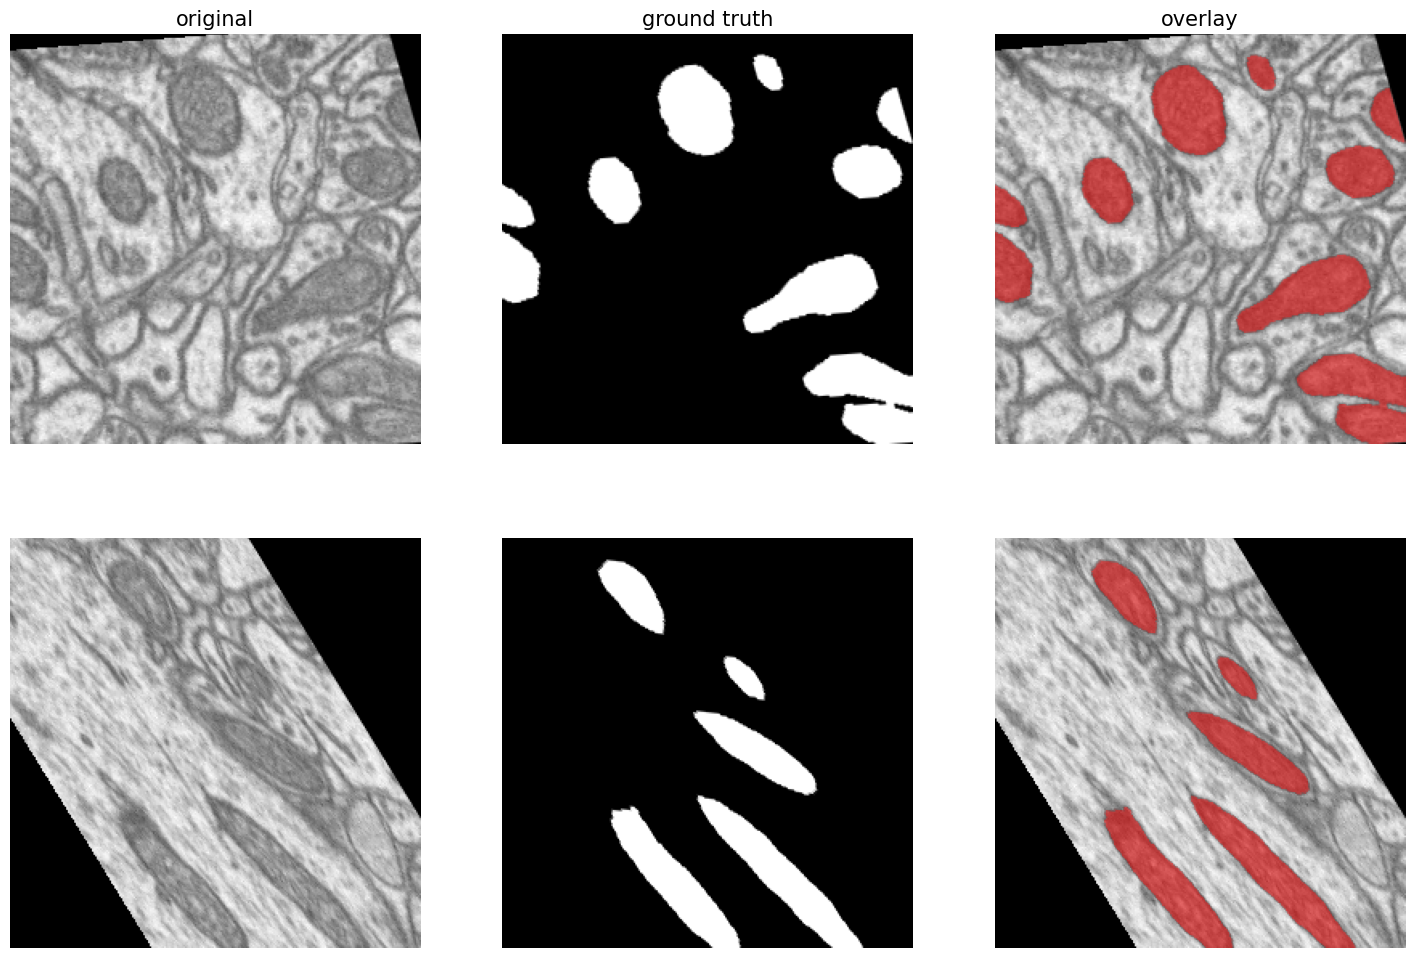

In [36]:
# Run the following code to visualize augmented examples.
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [37]:
#
# Now, we set up a U-Net classifier.
#
from keras_unet.models import custom_unet

model = custom_unet(
    X_train[0].shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

In [ ]:
# TODO: How many  trainable parameters does the model use?
# TODO: YOUR_ANSWER

In [ ]:
# There are a total of 31,030,593 trainable parameters.
# I found that by using model.summary(). 
#The last line gives the total number of trainable parameters.

In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 spatial_dropout2d (SpatialDrop  (None, 256, 256, 64  0          ['conv2d[0][0]']                 
 out2D)                         )                                                             

In [39]:
#
# Let's compile the model. Please use a LEARNING_RATE of 0.01
# and a MOMENTUM of 0.99.
#
LEARNING_RATE = 0.01
MOMENTUM = 0.99

In [40]:
#
# We will use Stochastic Gradient Descent as optimizer
# and use IoU as a metric.
#
from keras.optimizers import SGD
from keras_unet.metrics import iou, iou_thresholded

model.compile(
    optimizer=SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM),
    loss='binary_crossentropy',
    metrics=[iou, iou_thresholded]
)

In [ ]:
# TODO: Please explain Intersect-over-Union (IoU) in just a few sentences.
# TODO: YOUR_ANSWER

In [ ]:
#Intersection over Union is an evaluation metric used to measure the accuracy of 
#an object detector on a particular dataset.

In [ ]:
#
# Now let's train the model for 30 epochs!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use the train_gen from above as training data.
# Hint 2: Please don't forget (X_val, y_val) as validation data.
# Hint 3: steps_per_epoch should be set to all of the X_train.
# Hint 4: This will take roughly 30 minutes.
# Hint 5: If you are stuck, look through the repo of keras_unet!
#
history = model.fit(
    #
    # TODO: YOUR CODE
    #
)

In [42]:
history = model.fit(
    train_gen,
    epochs=30,
    steps_per_epoch=len(X_train),
    validation_data=(X_val, y_val)
)

Epoch 1/30
369/369 [==============================] - 105s 262ms/step - loss: 0.2198 - iou: 0.0676 - iou_thresholded: 0.0011 - val_loss: 0.1910 - val_iou: 0.1153 - val_iou_thresholded: 6.0699e-06
Epoch 2/30
369/369 [==============================] - 56s 151ms/step - loss: 0.1548 - iou: 0.1671 - iou_thresholded: 0.1051 - val_loss: 0.1587 - val_iou: 0.2016 - val_iou_thresholded: 6.0699e-06
Epoch 3/30
369/369 [==============================] - 57s 155ms/step - loss: 0.1399 - iou: 0.2388 - iou_thresholded: 0.2908 - val_loss: 0.1585 - val_iou: 0.2445 - val_iou_thresholded: 0.3300
Epoch 4/30
369/369 [==============================] - 58s 157ms/step - loss: 0.1199 - iou: 0.2998 - iou_thresholded: 0.3308 - val_loss: 0.0864 - val_iou: 0.5005 - val_iou_thresholded: 0.5825
Epoch 5/30
369/369 [==============================] - 57s 155ms/step - loss: 0.0921 - iou: 0.4093 - iou_thresholded: 0.4903 - val_loss: 0.0701 - val_iou: 0.5351 - val_iou_thresholded: 0.7021
Epoch 6/30
369/369 [================

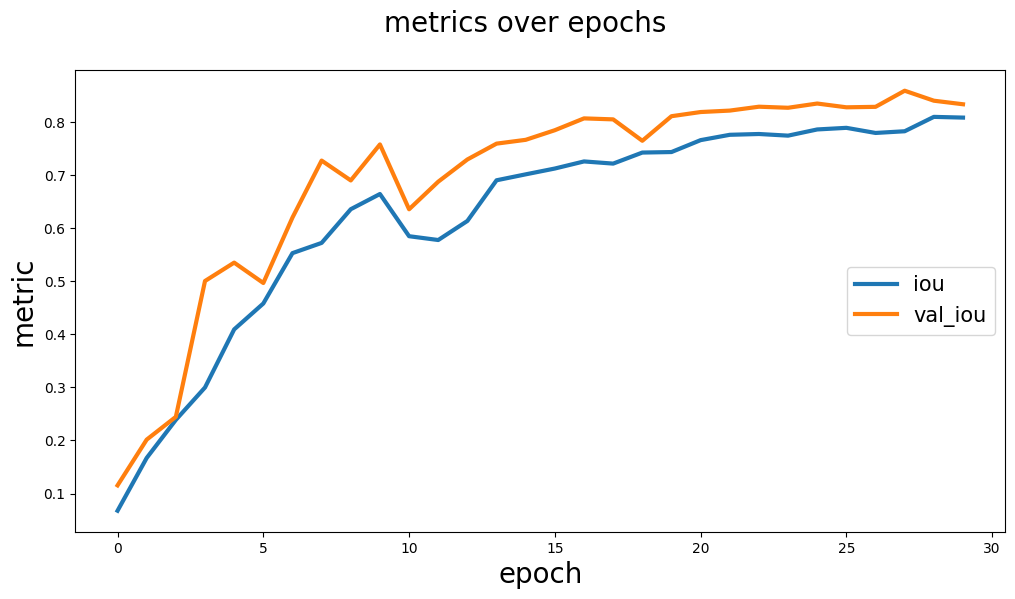

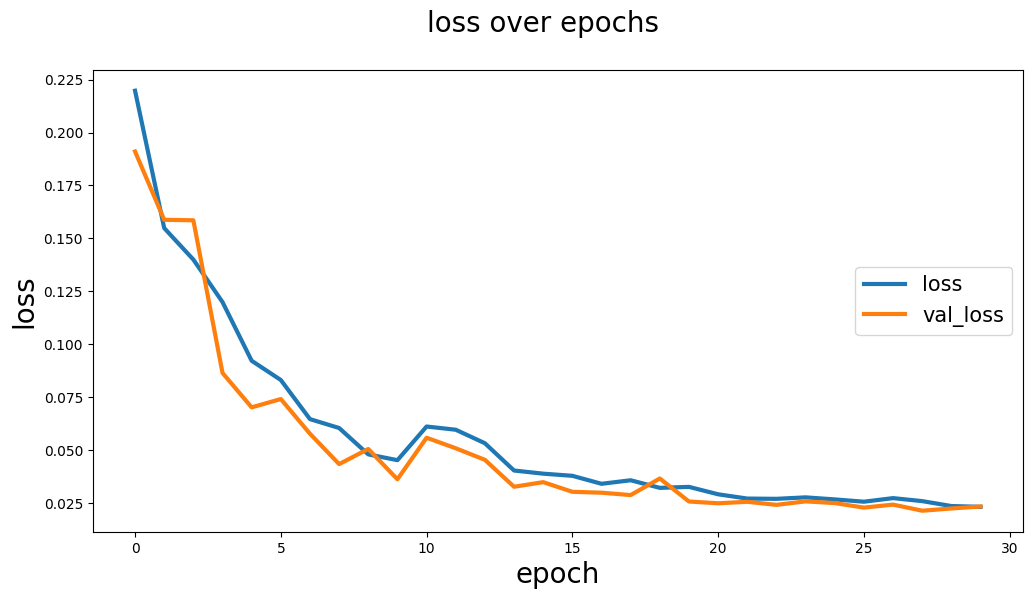

In [43]:
# We can use keras_unet functionality to visualize metrics and loss during training.
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [ ]:
# TODO: Do these plots look good to you?
# TODO: YOUR_ANSWER

In [ ]:
# Yes, the plots look good.

## 3. Evaluate U-Net (10 points)

In [44]:
# Let's predict all of X_test
y_pred = model.predict(X_test)

5/5 [==============================] - 5s 1s/step


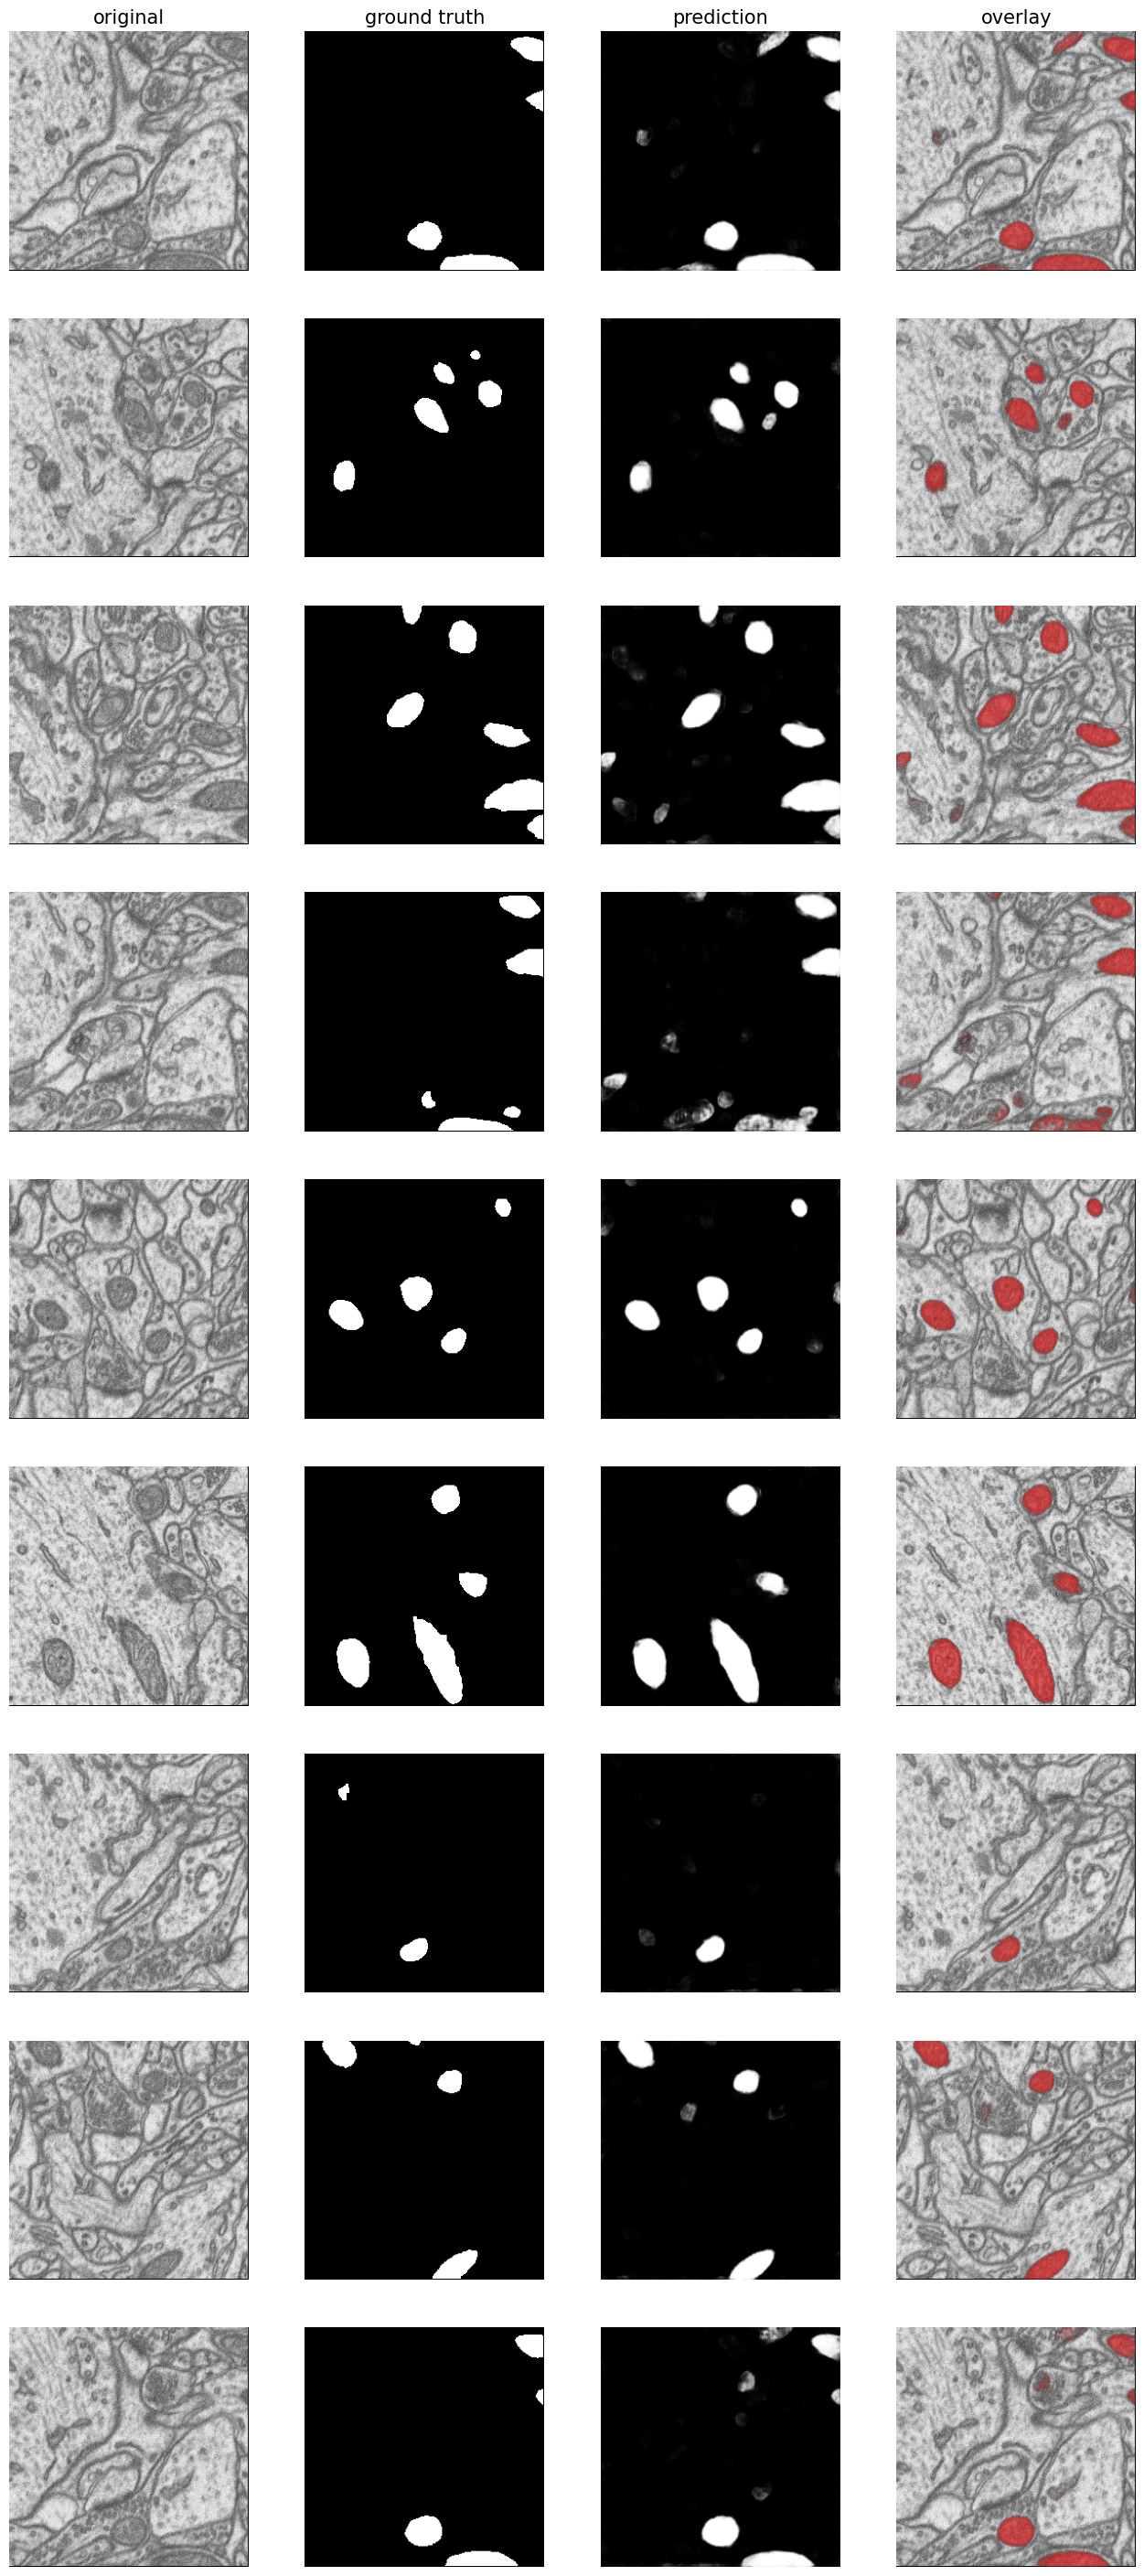

In [46]:
# ...and look at some results.
plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=9)

In [47]:
import sklearn.metrics

In [48]:
# Let's use the Jaccard score to compare a thresholded
# y_pred to the groundtruth y_test.
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

0.8911927173625269

In [ ]:
# TODO: What is the difference between Jaccard Score and Intersect-over-Union from above?
# TODO: YOUR_ANSWER 

In [ ]:
# The Jaccard Score and Intersection-over-Union (IoU) are both metrics used to evaluate the 
# performance of image segmentation models. 

# The main difference is in how they measure the similarity between the predicted and 
# ground truth segmentation masks. 
# The IoU is calculated as the ratio of the intersection between 
# the predicted and ground truth masks to their union, while the Jaccard Score is calculated as 
# the ratio of the intersection to the sum of the predicted and ground truth masks. 

In [ ]:
# TODO: Did the U-Net perform well on X_test?
# TODO: YOUR_ANSWER

In [ ]:
#Yes, it performed well.

## 4. Combine U-Net with SAM (10 points)

In [ ]:
# Instead of running SAM in auto mode without seeds (Task 1), we will now
# use the U-Net predictions on X_test to seed the SAM model.

In [ ]:
# We can use the following convenience functions
# to 1) convert mahotas bounding boxes to SAM format
# and 2) combine the SAM output tensors to a mask.

In [49]:
def mahotas_bbox_to_sam(bbs):

  new_bbs = []

  for i,bb in enumerate(bbs):
    # from (y1, y2, x1, x2)
    # to (x1, y1, x2, y2)
    if i == 0:
      continue
    new_bb = [bb[2], bb[0], bb[3], bb[1]]
    new_bbs.append(new_bb)

  return new_bbs

In [50]:
def sam_to_mask(results):

  results = results.cpu() # copy back to cpu land

  mask = np.array(results[0,0])

  for s in results:
    mask[s[0] == 1] = 1

  return mask

In [ ]:
# The following code combines the U-Net predictions with SAM.
#
# TODO: Please study the code and answer the TODOs in-line.

In [ ]:
y_pred_sam = y_pred.copy()
y_pred_sam[:] = 0

for z,img in enumerate(X_test):

  # TODO: EXPLAIN CODE BELOW
  mh.imsave('test.png', (img[:,:,0]*255).astype(np.uint8))

  # TODO: EXPLAIN CODE BELOW
  pred = (y_pred[z] > 0.5)

  # TODO: EXPLAIN CODE BELOW
  pred, _ = mh.labeled.label(pred)
  
  # TODO: EXPLAIN CODE BELOW
  bbs = mh.labeled.bbox(pred)

  # TODO: EXPLAIN CODE BELOW
  bbs_converted = mahotas_bbox_to_sam(bbs)

  # TODO: EXPLAIN CODE BELOW
  results = SegManualMaskPredictor().image_predict(
      source="test.png",
      model_type="vit_l", # vit_l, vit_h, vit_b
      input_box=bbs_converted, 
      multimask_output=False,
      random_color=False,
      show=False,
      save=False,
  )

  # TODO: EXPLAIN CODE BELOW
  sam_and_unet_pred = sam_to_mask(results)

  # TODO: EXPLAIN CODE BELOW
  y_pred_sam[z,:,:,0] = sam_and_unet_pred

In [52]:
y_pred_sam = y_pred.copy()
y_pred_sam[:] = 0

for z,img in enumerate(X_test):

  # Saving the test image as 'test.png'
  mh.imsave('test.png', (img[:,:,0]*255).astype(np.uint8))

  # Threshold the predicted mask to 0s and 1s based on a threshold of 0.5
  pred = (y_pred[z] > 0.5)

  # Labelling the connected regions in the thresholded mask
  pred, _ = mh.labeled.label(pred)

  # Getting the bounding boxes for each labeled region in the thresholded mask
  bbs = mh.labeled.bbox(pred)

  # Converting the bounding boxes to the format used by the SAM model
  bbs_converted = mahotas_bbox_to_sam(bbs)

  # Using the SAM model to predict masks for each bounding box
  results = SegManualMaskPredictor().image_predict(
      source="test.png",
      model_type="vit_l", # vit_l, vit_h, vit_b
      input_box=bbs_converted, 
      multimask_output=False,
      random_color=False,
      show=False,
      save=False,
  )

  # Converting the SAM model predictions to a mask
  sam_and_unet_pred = sam_to_mask(results)

  # Assigning the SAM and U-Net predictions to the corresponding slice of y_pred_sam
  y_pred_sam[z,:,:,0] = sam_and_unet_pred


vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l mo

## 5. Compare U-Net vs. U-Net+SAM. (10 points)

In [53]:
# U-Net performance on X_test (from Task 3)
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

0.8911927173625269

In [54]:
# U-Net + SAM performance on X_test
sklearn.metrics.jaccard_score(y_test.ravel(), y_pred_sam.ravel())

0.8512657174569592

In [ ]:
# TODO: Please explain the results - is U-Net+SAM a good addition?
# TODO: YOUR_ANSWER

In [ ]:
# I don't think U-Net + SAM is a good addition because we are getting a 
# relatively low jaccard score as compared to U-Net performanec on X_Test.

## Bonus: Improve the results. (33 points)

In [ ]:
# Please improve the results of U-Net+SAM and show the improved Jaccard score.

In [ ]:
# TODO: YOUR_CODE

In [55]:
y_pred_sam = y_pred.copy()
y_pred_sam[:] = 0

for z,img in enumerate(X_test):

  # Save the test image as 'test.png'
  mh.imsave('test.png', (img[:,:,0]*255).astype(np.uint8))

  # Threshold the predicted mask to 0s and 1s based on a threshold of 0.7
  pred = (y_pred[z] > 0.7)

  # Label the connected regions in the thresholded mask
  pred, _ = mh.labeled.label(pred)

  # Get the bounding boxes for each labeled region in the thresholded mask
  bbs = mh.labeled.bbox(pred)

  # Convert the bounding boxes to the format used by the SAM model
  bbs_converted = mahotas_bbox_to_sam(bbs)

  # Use the SAM model to predict masks for each bounding box
  results = SegManualMaskPredictor().image_predict(
      source="test.png",
      model_type="vit_l", # vit_l, vit_h, vit_b
      input_box=bbs_converted, 
      multimask_output=False,
      random_color=False,
      show=False,
      save=False,
  )

  # Convert the SAM model predictions to a mask
  sam_and_unet_pred = sam_to_mask(results)

  # Assign the SAM and U-Net predictions to the corresponding slice of y_pred_sam
  y_pred_sam[z,:,:,0] = sam_and_unet_pred

vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l mo

In [56]:
# U-Net + SAM performance on X_test
sklearn.metrics.jaccard_score(y_test.ravel(), y_pred_sam.ravel())

0.8676428977771953

In [ ]:
# By setting the threshold value to 0.7, the jaccard_score gets slightly better with a score of 0.868. 

In [ ]:
#Citations:-
# To uderstand IoU - https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

In [ ]:
#
# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#